# Section III: Analysis

In this notebook the trajectory produced in the simulation section is analyzed. The following parameters are calculated: 
- Area per lipid (APL)
- Tilt Angle
- Nematic Order Parameter (S2)
- Neutron Scattering Length Density (NSLD)
- Bilayer Height

Load the final trajectory into MDTraj and ensure that the correct number of frames (2001), atoms (15288), and residues (2952) are present.

In [1]:
from copy import deepcopy

import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

traj = md.load("../simulation/5_prod/traj_wrapped.xtc", top="../simulation/5_prod/confout.gro")
print(traj)

<mdtraj.Trajectory with 2001 frames, 15288 atoms, 2952 residues, and unitcells>


## Area Per Lipid

The area per lipid is calculated as the cross sectional area divided by the number of lipids for each leaflet.

In [2]:
# Get box area: Lx * Ly
area = traj.unitcell_lengths[:,0] * traj.unitcell_lengths[:,1]

# Specify the number of lipids and number of leaflets in the system
number_of_lipids = 72
number_of_leaflets = 2

# Calculate the area per lipid: the area divided by the number of lipids per leaflet
apl = area / (number_of_lipids / number_of_leaflets)

# Determine the average area per lipid and convert to square angstroms
apl_mean = np.mean(apl) * 100

print(f"The average area per lipid is {apl_mean:.2f} Å^2")

The average area per lipid is 32.90 Å^2


## Tilt Angle

The tilt angle is the angle between the lipid tail director and the bilayer normal. See [Moore, et al, 2018](https://doi.org/10.1016/j.bpj.2017.10.031) for more details.

In [3]:
# Dictionary defining the tail indices for each lipid type
tail_indices = {"cer"  : tuple([np.arange(0, 74),    # Sphingosine tail
                               np.arange(74, 129)]), # Fatty Acid Tail
                "ffa"  : tuple([np.arange(0, 74)]),   # Whole molecule
                "chol" : tuple([np.arange(0, 74)])    # Whole molecule
               }

# Inititalize list of tails and populate with indices of each tail
tails = []
for residue in traj.top.residues:
    if residue.name == "tip3p":
        continue
    residue_tails = tail_indices[residue.name]
    residue_indices = np.array([atom.index for atom in residue.atoms])
    for tail in residue_tails:
        tails.append(list(residue_indices.take(tail)))

# Ensure that each element in the list of indices is an int
for i in range(len(tails)):
    for j in range(len(tails[i])):
        tails[i][j] = int(tails[i][j])
        
# Compute the directors for each tail and reshape to make an (:,3) shape list.
directors = md.compute_directors(traj=traj, indices=tails)#.reshape(-1, 3)

# Compute the angle between the bilayer normal vector ([0, 0, +/- 1]) and the director
dot_product = np.dot(directors, np.array([0, 0, 1]))
angles = np.arccos(dot_product) * 180.0 / np.pi

# Make sure that angles are below 90 degrees
angles = angles + (angles > 90) * (180 - 2*angles)

# Get the average tilt angle over all lipids over all frames
angles_mean = np.mean(angles)

print(f"The average tilt angle is {angles_mean:.1f}°")


The average tilt angle is 10.8°


## Nematic Order Parameter

The nematic order parameter is calculated by determining the largest eigenvalue of the Q-tensor. See [Moore, et al, 2018](https://doi.org/10.1016/j.bpj.2017.10.031) for more details.

In [4]:
# We can use the same definition of the tail indices as in the tilt angle calculation (see above)
# Compute the nematic order using MDTraj
s2 = md.compute_nematic_order(traj=traj, indices=tails)

# Get the average nematic order over all frames
s2_mean = np.mean(s2)

print(f"The average nematic order is {s2_mean:.4f}")

The average nematic order is 0.9414


## Neutron Scattering Length Density

The NSLD is calculated by plotting a z-profile histogram of the system weighted by the scattering length. This is normalized by the volume of the slice. Scattering lengths for each atom/isotope are found here: https://www.ncnr.nist.gov/resources/n-lengths/ 

In [5]:
# Define scattering lengths for each element
scattering_length = {"hydrogen" : -3.74,
                     "deuterium" : 6.671,
                     "carbon"     : 6.6511,
                     "nitrogen"   : 9.37,
                     "oxygen"     : 5.803
                    }

The total neutron scattering length density is calculated and plotted below. 

Text(0, 0.5, 'NSLD (A.u.)')

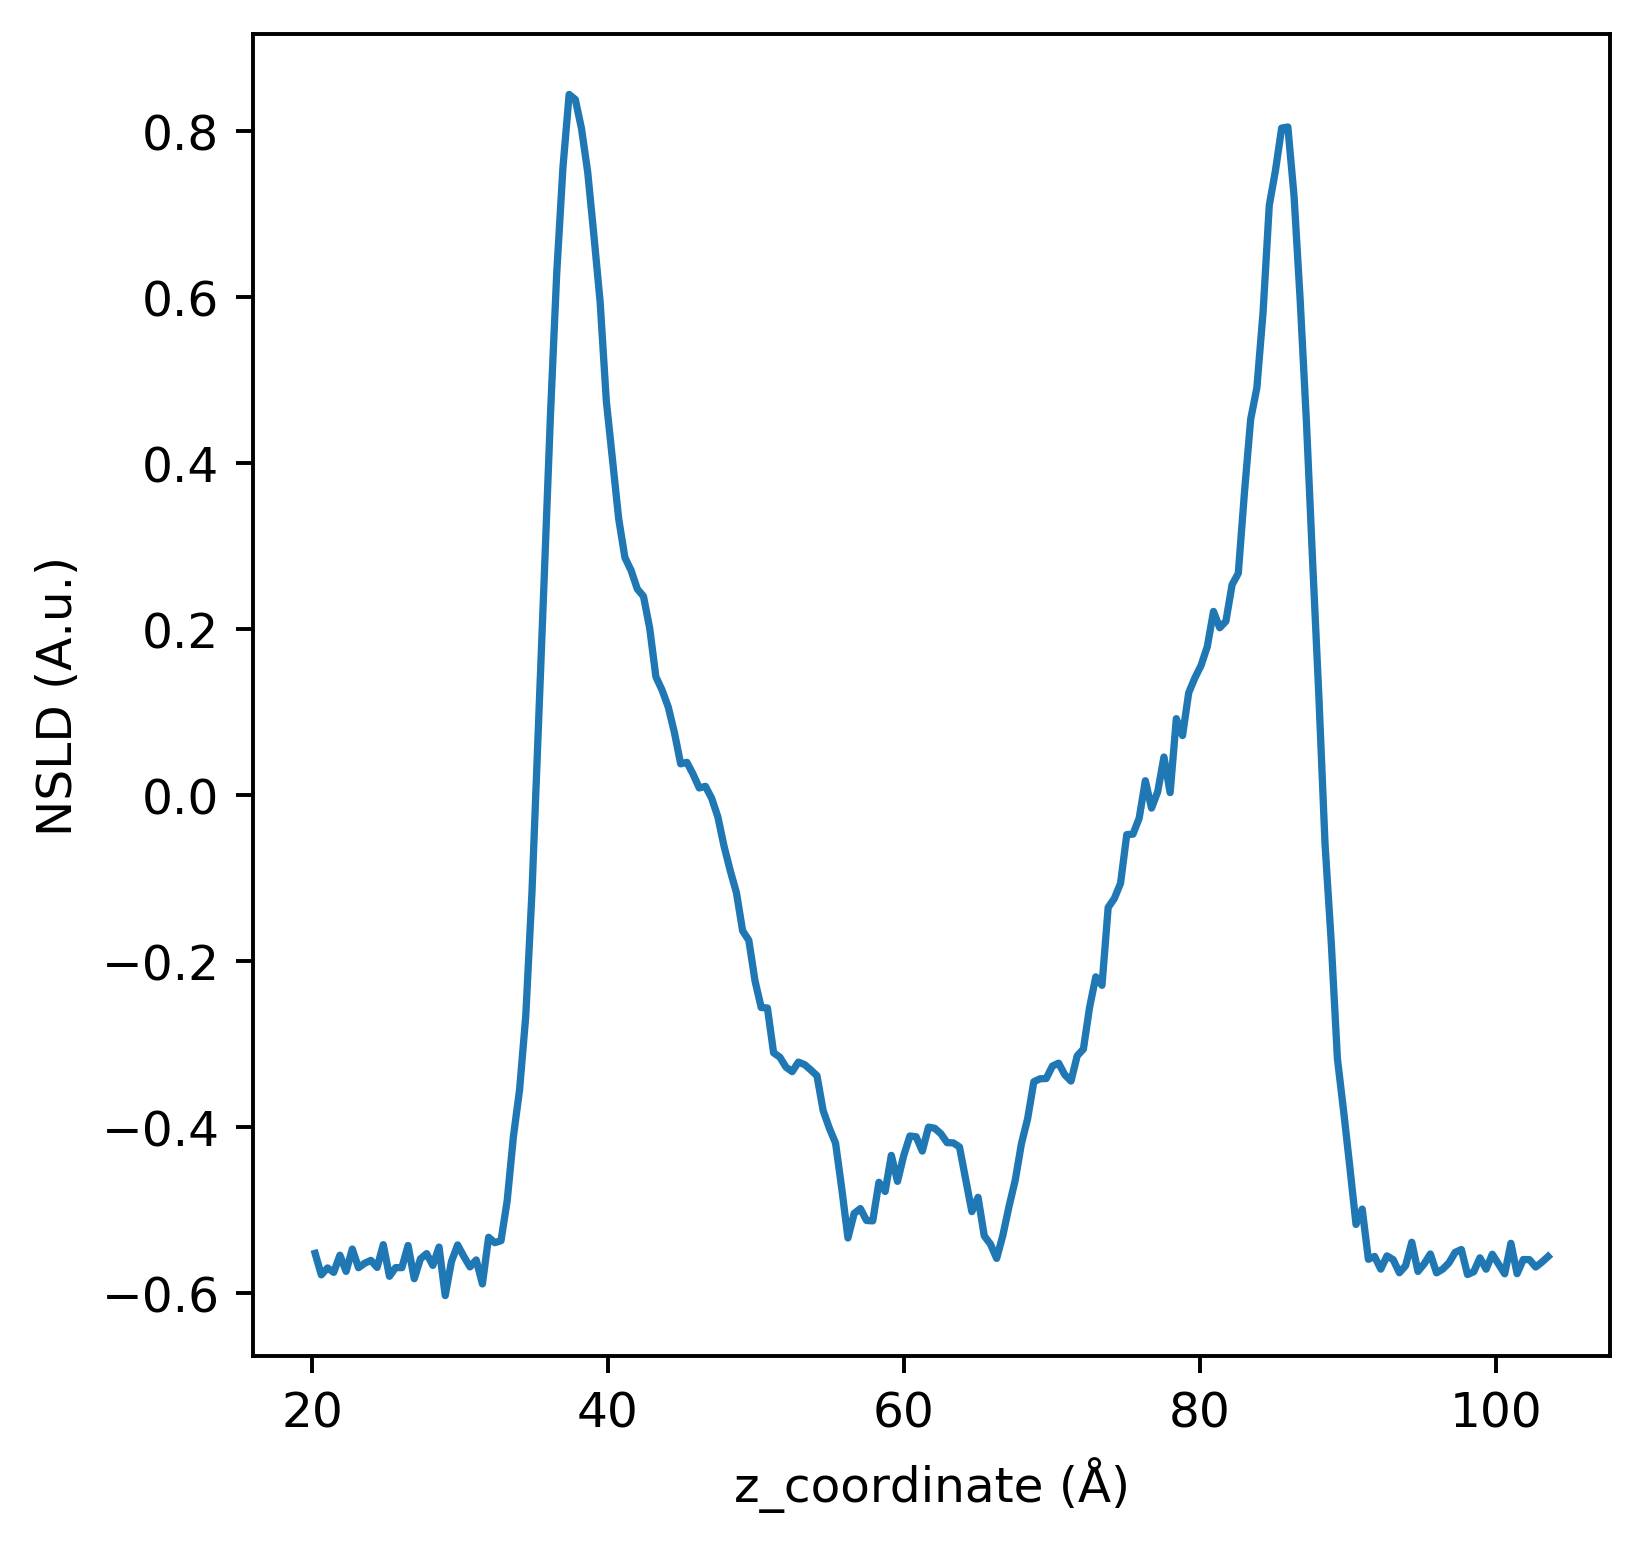

In [6]:
# Get a list of scattering lengths for each index
scattering_lengths = [scattering_length[atom.element.name] for atom in traj.top.atoms]

# Compute a histogram of the total scattering length vs the z-coordinate.
nsld, edges = np.histogram(traj.xyz[:,:,2].reshape(-1), 
                          range=[2,np.mean(traj.unitcell_lengths[:,2])-2],
                          bins=200,
                          weights=np.array(scattering_lengths*traj.n_frames))
bins = (edges[1:] + edges[:-1]) * 0.5

# Divide by number of frames
nsld /= traj.n_frames

# Divide by bin width and box area to get density
nsld /= (bins[1]-bins[0]) * np.mean(traj.unitcell_lengths[:,0] * traj.unitcell_lengths[:,1])

# Convert to angstroms and plot the scattering length density
plt.figure(dpi=350, figsize=[5, 5])
plt.plot(bins*10, nsld*0.01, label="Total NSLD")

plt.xlabel("z_coordinate (Å)")
plt.ylabel("NSLD (A.u.)")

In addition, the deuterated profiles for each lipid type (assuming that all hydrogens in the molecule are deuterated) are also plotted.

Text(0, 0.5, 'NSLD (A.u.)')

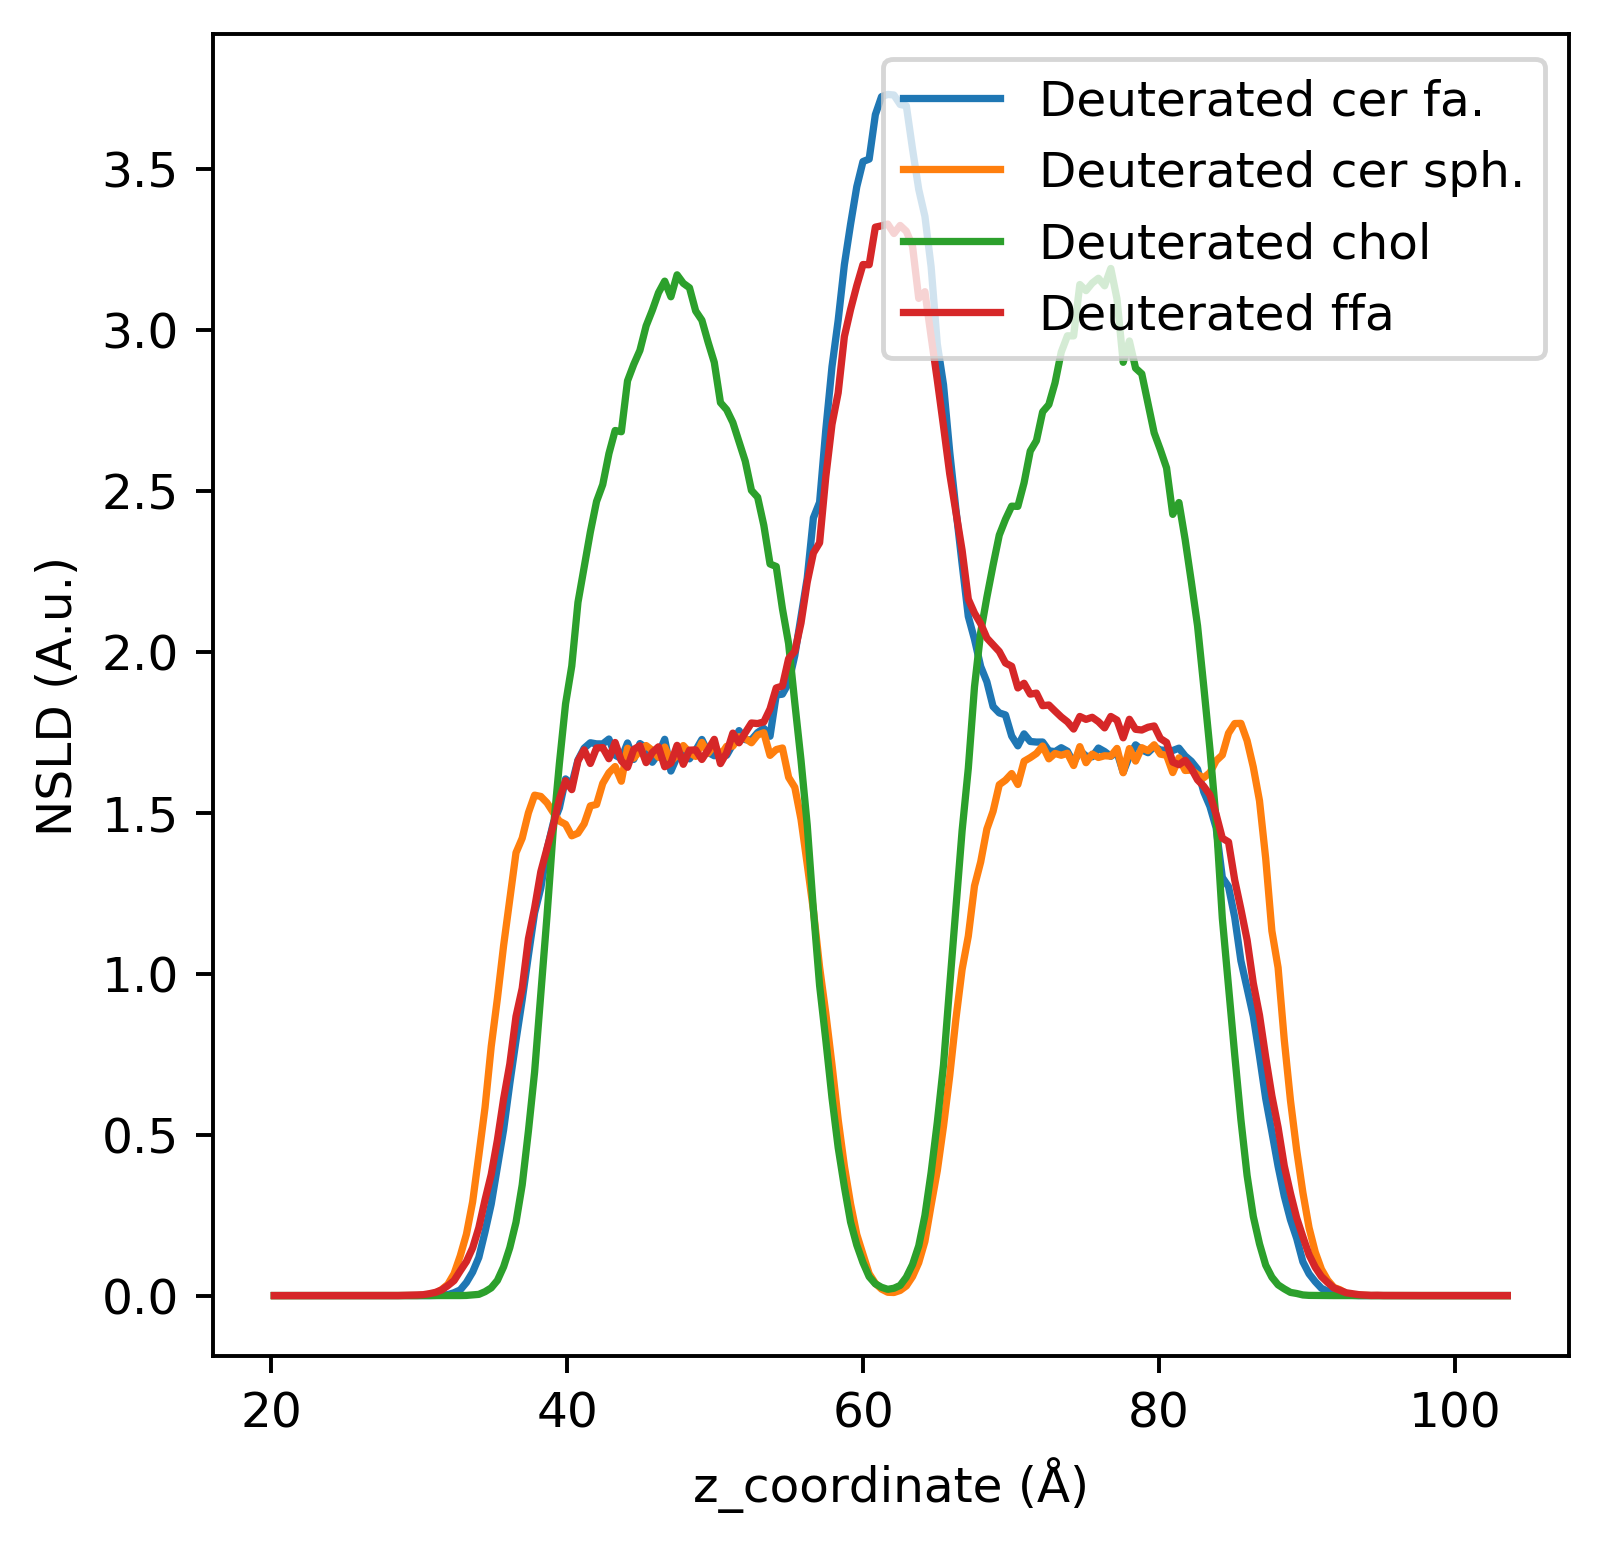

In [7]:
def plot_deuterated_NSLD(profile_name, deuteriums):
    """Worker function to calculate deuterated profile and plot to a matplotlib Figure. """
    scattering_lengths_deuterated = deepcopy(scattering_lengths)
    for deuterium in deuteriums:
        scattering_lengths_deuterated[deuterium] = scattering_length["deuterium"]
    
    nsld_deuterated, edges = np.histogram(traj.xyz[:,:,2].reshape(-1), 
                                          range=[2,np.mean(traj.unitcell_lengths[:,2])-2],
                                          bins=200,
                                          weights=np.array(scattering_lengths_deuterated*traj.n_frames))
    bins = (edges[1:] + edges[:-1]) * 0.5
    nsld_deuterated /= traj.n_frames
    nsld_deuterated /= (bins[1]-bins[0]) * np.mean(traj.unitcell_lengths[:,0] * traj.unitcell_lengths[:,1])
    
    # Subtract the protonated NSLD from the deuterated
    nsld_deuterated = nsld_deuterated - nsld
    plt.plot(bins*10, nsld_deuterated*0.01, label=f"Deuterated {profile_name}")
    
# Repeat for each lipid type with deuteration
plt.figure(dpi=350, figsize=[5, 5])

for lipid_name in ("cer", "chol", "ffa"):
    if lipid_name == "cer":
        # Sphingosine tails
        for tail_number, tail_name in enumerate(["cer fa.", "cer sph."]):
            deuteriums = []
            for residue in traj.top.residues:
                if residue.name in {"tip3p", "chol", "ffa"}:
                    continue
                residue_tails = tail_indices[residue.name]
                residue_indices = np.array([atom.index for atom in residue.atoms])
                deuteriums.append(residue_indices.take(residue_tails[tail_number]))
            deuteriums = np.array(deuteriums).reshape(-1)
            plot_deuterated_NSLD(tail_name, deuteriums)
        
    else:
        deuteriums = traj.top.select(f"resname {lipid_name} and element H")
        plot_deuterated_NSLD(lipid_name, deuteriums)

plt.legend()

plt.xlabel("z_coordinate (Å)")
plt.ylabel("NSLD (A.u.)")

Finally, the bilayer height calculated by measuring the distance between the two peaks of the NSLD, which correspond to the location of the location head groups.

In [8]:
# Find peaks in the NSLD using the find_peaks function in the scipy package
peaks, properties = find_peaks(nsld, height=60, distance=50)

# Make sure that there are only 2 peaks found. 
# If there are more or less, there is something wrong with the trajectory
assert len(peaks) == 2

# Calculate the height (difference z-positions) and convert to Angstroms.
height = (bins[peaks[1]] - bins[peaks[0]]) * 10

print(f"The average bilayer height is {height:.2f} Å")

The average bilayer height is 48.58 Å


## Discussion

According to the deuterated NSLD plots, we can see that there is significant interdigitation of the ceramide fatty acid and free fatty acid tails, which both contain 24 carbons, indicated by the large high-density peak at the center of the bilayer. The shorter 16-carbon sphingosine chain has a low-density trough at the center of the bilayer similar to the behavior of cholesterol, which suggests that these lipids do not interdigitate. It is also evident that the cholesterol molecules are located closer to the center of the bilayer than the other lipids. 

This experiment can be further expanded by screening several compositions or water content to examine the effect of varying these parameters on the structure of the bilayer.  